In [1]:
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import load_model

import cv2
import os
import matplotlib.pyplot as plt

import numpy as np

from patchify import patchify, unpatchify

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# Load the model you trained in task5_training.ipynb
patch_size = 256
example_file_name = f'PetarPaskalev_232725_unet_model_2_256px_80F1.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [4]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 2)
image.shape
h, w = image.shape
print(h, w)

3006 4112


In [5]:
# Load and preprocess images

def load_and_preprocess_image(image):
    # Load image
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    return image, blurred_image

# Find the boundaries of the Petri dish by scanning pixel values
def detect_edges(image, max_size=2800):
    """ Detect edges to find the approximate square Petri dish. """
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)
 
    # Compute horizontal and vertical gradients
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)
 
    # Calculate the gradient magnitude
    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)
 
    # Threshold to identify strong edges
    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
    edges = edges.astype(np.uint8)
 
    # Find contours to identify the Petri dish
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
    # Assume the largest square-like contour is the Petri dish
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
 
    # Ensure the crop is a square, adjust dimensions as needed
    side_length = max(w, h)
    side_length = min(side_length, max_size)  # Clamp to max_size
 
    center_x, center_y = x + w // 2, y + h // 2
    half_side = side_length // 2
 
    # Define new bounding box that is a square centered at the original bounding box
    new_x = max(center_x - half_side, 0)
    new_y = max(center_y - half_side, 0)
    new_w = new_h = min(side_length, min(image.shape[1] - new_x, image.shape[0] - new_y))
 
    return new_x, new_x + new_w, new_y, new_y + new_h
 

In [6]:
edges = detect_edges(image)
print("Detected Edges:", edges)

Detected Edges: (747, 3547, 52, 2852)


In [7]:
def crop_image(image, edges, max_size=2800):
    """ Crop and resize the image to ensure dimensions are below the threshold. """
    left, right, top, bottom = edges
    cropped = image[top:bottom, left:right]
 
    # Resize if necessary
    if cropped.shape[1] > max_size or cropped.shape[0] > max_size:
        cropped = cv2.resize(cropped, (min(cropped.shape[1], max_size), min(cropped.shape[0], max_size)))
 
    return cropped

In [8]:
cropped_image = crop_image(image, edges)
print("Cropped Image Shape:", cropped_image.shape)

Cropped Image Shape: (2800, 2800)


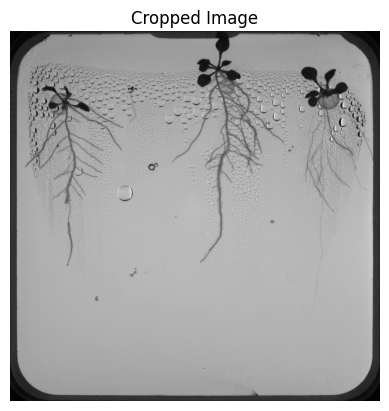

In [9]:
# Display the cropped image
plt.figure(dpi=100)
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Image")
plt.axis('off')
plt.show()

In [10]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 2)
image.shape
h, w = image.shape
print(h, w)

3006 4112


In [11]:
image.shape

(3006, 4112)

In [12]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [13]:
petri_dish_padded = padder(cropped_image, 256)


In [14]:
# Pad the petri dish
petri_dish_padded.shape

(2816, 2816)

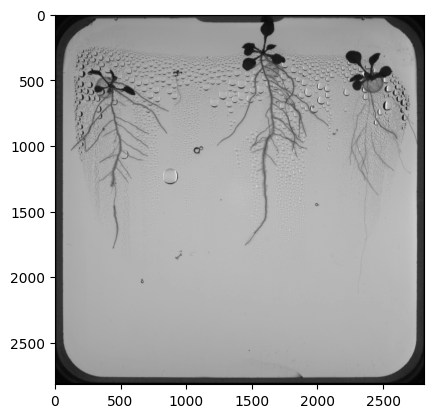

In [15]:
plt.imshow(petri_dish_padded, cmap='gray')

In [16]:
# PATCH

patch_size = 256

patches = patchify(petri_dish_padded, (patch_size, patch_size), step=patch_size)

patches.shape

(11, 11, 256, 256)

In [17]:
# Reshape patches to flatten the grid dimensions
patches_reshaped = patches.reshape(-1, patch_size, patch_size, 1)  # Add channel dimension for grayscale

# Normalize patches
patches_normalized = patches_reshaped / 255.0

patches_normalized.shape

(121, 256, 256, 1)

In [18]:
# Predict using the model
predictions = model.predict(patches_normalized, batch_size=16)

8/8 [==============================] - 8s 160ms/step


In [19]:
# Reshape predictions back to (11, 11, 256, 256)
predictions = predictions.reshape(11, 11, patch_size, patch_size)

In [20]:
predicted_image = unpatchify(predictions, petri_dish_padded.shape)

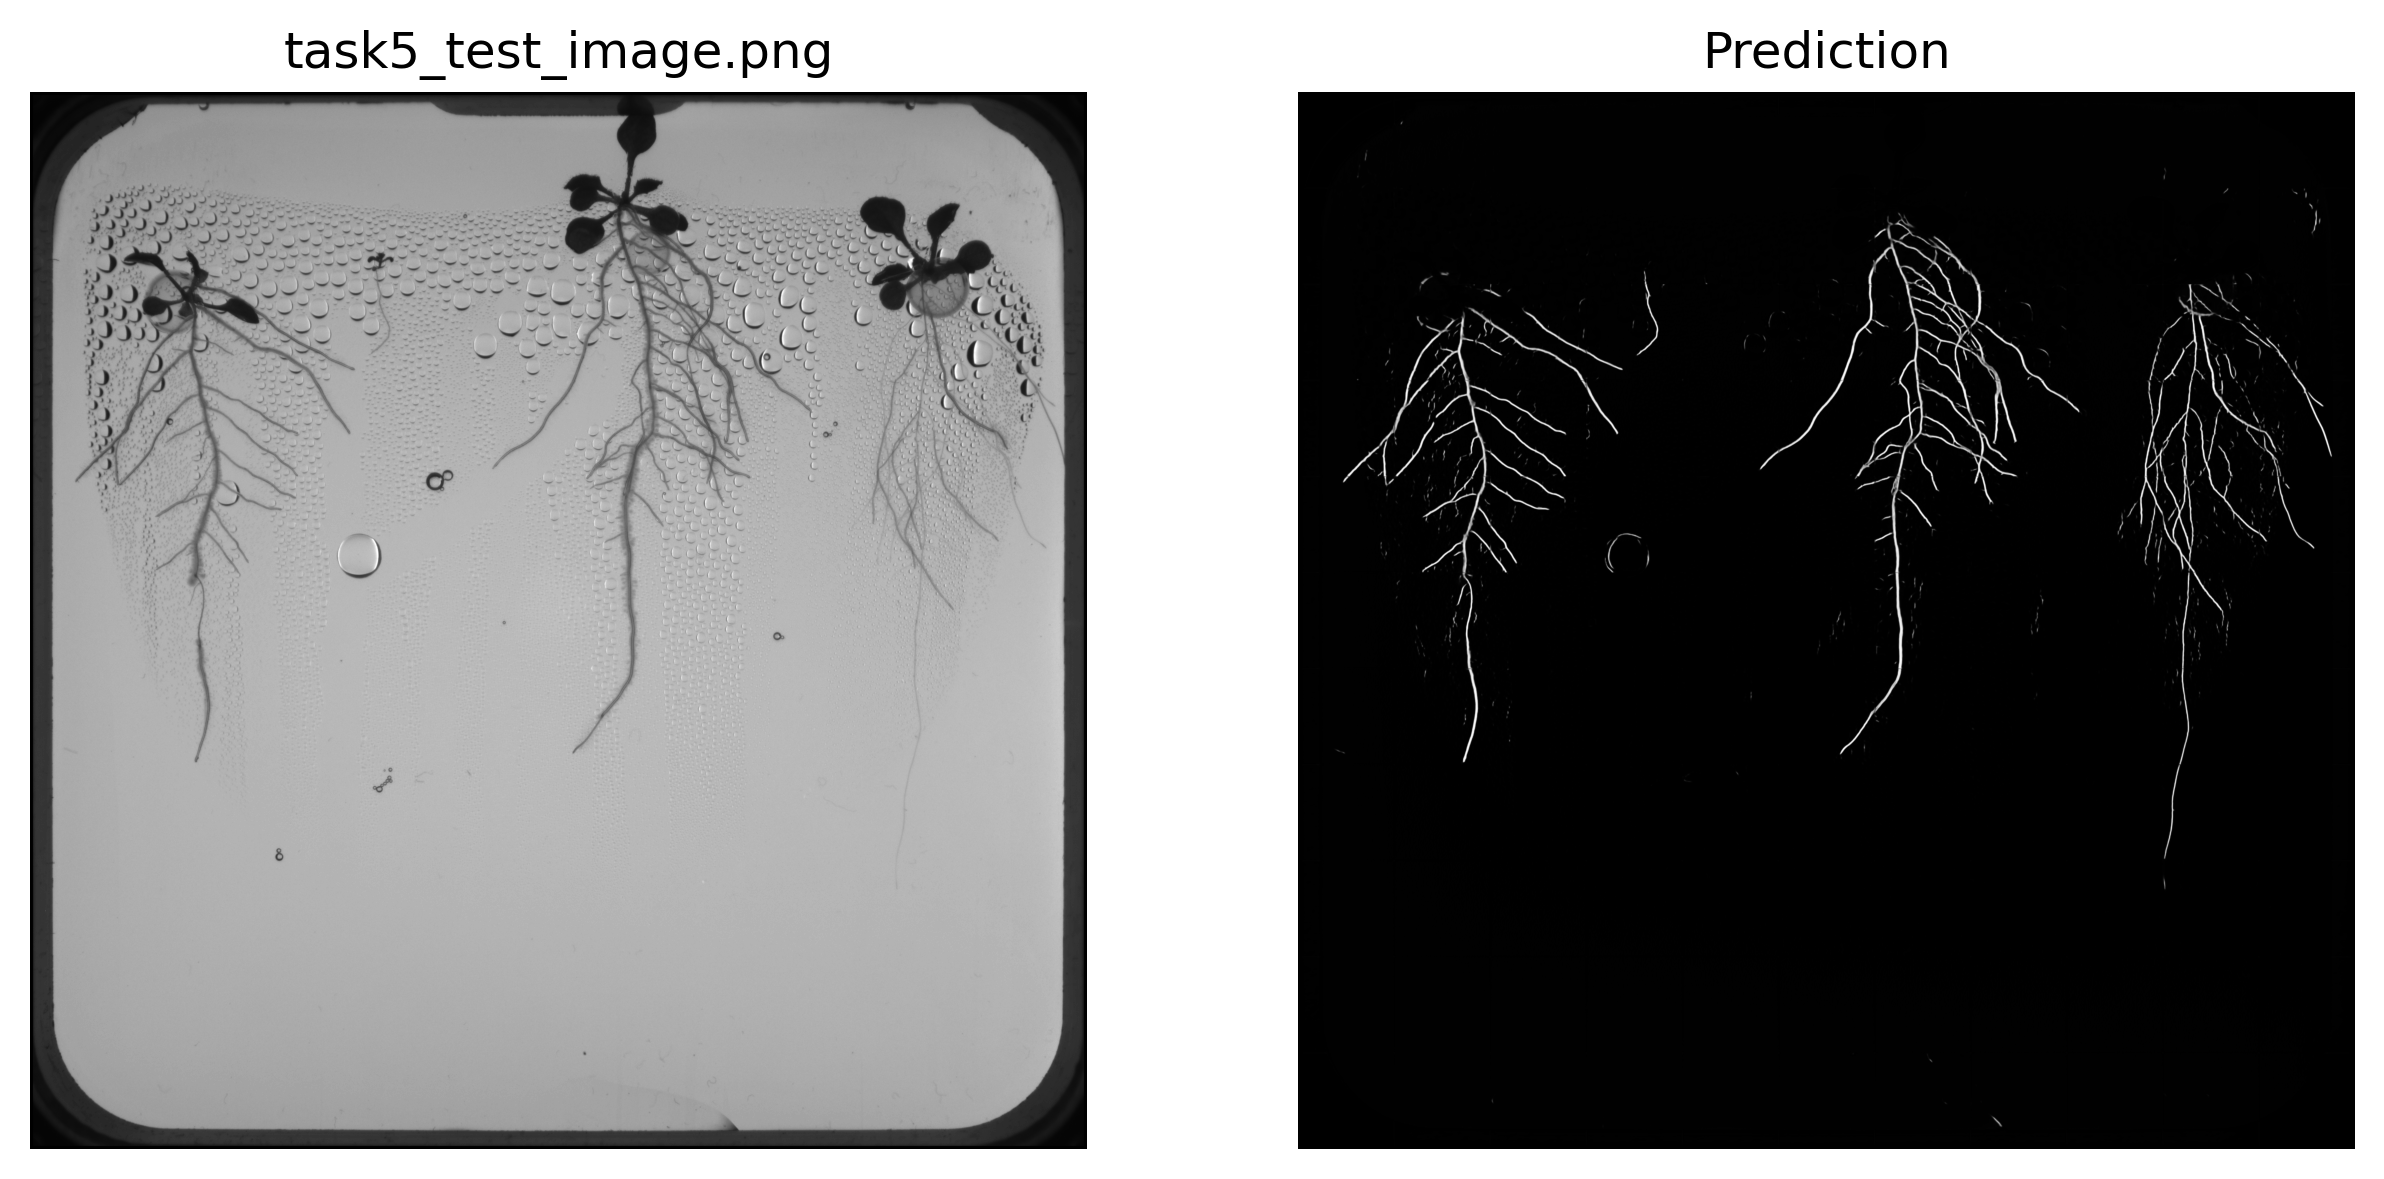

In [21]:
predicted_mask = predicted_image

f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')  # Original padded image
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

plt.show()


In [22]:
predicted_mask.shape, image.shape

((2816, 2816), (3006, 4112))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [23]:
def reverse_padding(mask, original_shape):
    """ Remove padding to match the original image dimensions. """
    return mask[:original_shape[0], :original_shape[1]]

# Reverse padding
predicted_mask_corrected = reverse_padding(predicted_mask, petri_dish_padded.shape)
print("Shape after reversing padding:", predicted_mask_corrected.shape)


Shape after reversing padding: (2816, 2816)


In [24]:
# Print the crop coordinates (edges)
print("Crop Coordinates (edges):", edges)

# Ensure the edges make sense relative to the original image shape
print("Original Image Shape:", image.shape)


Crop Coordinates (edges): (747, 3547, 52, 2852)
Original Image Shape: (3006, 4112)


In [25]:
# Compute the expected crop dimensions
expected_height = edges[3] - edges[2]
expected_width = edges[1] - edges[0]
print("Expected Cropped Mask Shape:", (expected_height, expected_width))

# Actual cropped mask shape
print("Cropped Mask Shape:", predicted_mask_corrected.shape)

# Check if they match
if predicted_mask_corrected.shape == (expected_height, expected_width):
    print("Cropped mask dimensions match the expected crop size.")
else:
    print("Mismatch in cropped mask dimensions!")


Expected Cropped Mask Shape: (2800, 2800)
Cropped Mask Shape: (2816, 2816)
Mismatch in cropped mask dimensions!


In [26]:
# Calculate padding added during the padding step
pad_h = predicted_mask_corrected.shape[0] - 2800
pad_w = predicted_mask_corrected.shape[1] - 2800
print("Padding Added - Height:", pad_h, "Width:", pad_w)


Padding Added - Height: 16 Width: 16


In [ ]:
def uncrop_image(cropped_mask, original_shape, crop_coordinates):
    """ Embed the cropped mask into the original image dimensions. """
    full_mask = np.zeros(original_shape, dtype=cropped_mask.dtype)
    x_start, x_end, y_start, y_end = crop_coordinates
    full_mask[y_start:y_end, x_start:x_end] = cropped_mask
    return full_mask

# Assuming crop coordinates were stored during preprocessing
crop_coordinates = edges  # Replace with the actual variable where you stored crop coordinates
predicted_mask_corrected = uncrop_image(predicted_mask_corrected, image.shape, crop_coordinates)
print("Shape after reversing cropping:", predicted_mask_corrected.shape)

# Ensure alignment
assert predicted_mask_corrected.shape == image.shape, "Shapes still do not align!"

In [28]:
# Remove padding from the predicted mask
predicted_mask_corrected = predicted_mask_corrected[:2800, :2800]
print("Shape after removing padding:", predicted_mask_corrected.shape)


Shape after removing padding: (2800, 2800)


In [29]:
# Embed the cropped mask into the original image
predicted_mask_corrected = uncrop_image(predicted_mask_corrected, image.shape, edges)
print("Shape after uncropping:", predicted_mask_corrected.shape)

# Ensure alignment
assert predicted_mask_corrected.shape == image.shape, "Shapes still do not align!"


Shape after uncropping: (3006, 4112)


In [30]:
# Convert the mask to binary: Non-root pixels = 0, root pixels = 255
predicted_mask_binary = (predicted_mask_corrected > 0.5).astype(np.uint8) * 255
print("Binary Mask Unique Values:", np.unique(predicted_mask_binary))  # Should print [0, 255]


Binary Mask Unique Values: [  0 255]


In [31]:
# Ensure both are in uint8 and [0, 255] range
if image.dtype != np.uint8:
    image = (image / image.max() * 255).astype(np.uint8)

if predicted_mask_binary.dtype != np.uint8:
    predicted_mask_binary = (predicted_mask_binary / predicted_mask_binary.max() * 255).astype(np.uint8)


In [32]:
print("Original Image - Data Type:", image.dtype, "| Min:", image.min(), "| Max:", image.max())
print("Predicted Mask - Data Type:", predicted_mask_binary.dtype, "| Min:", predicted_mask_binary.min(), "| Max:", predicted_mask_binary.max())


Original Image - Data Type: uint8 | Min: 0 | Max: 255
Predicted Mask - Data Type: uint8 | Min: 0 | Max: 255


In [33]:
# Verify crop coordinates (edges)
print("Crop Coordinates (edges):", edges)

# Ensure the coordinates fit within the original image dimensions
print("Original Image Shape:", image.shape)
assert 0 <= edges[0] < edges[1] <= image.shape[1], "Horizontal crop coordinates are out of bounds!"
assert 0 <= edges[2] < edges[3] <= image.shape[0], "Vertical crop coordinates are out of bounds!"


Crop Coordinates (edges): (747, 3547, 52, 2852)
Original Image Shape: (3006, 4112)


In [34]:
# Expected cropped mask shape
cropped_height = edges[3] - edges[2]
cropped_width = edges[1] - edges[0]
print("Expected Cropped Mask Shape:", (cropped_height, cropped_width))

# Padded mask shape
print("Padded Mask Shape (before patching):", petri_dish_padded.shape)

# Check padding amounts
pad_h = petri_dish_padded.shape[0] - cropped_height
pad_w = petri_dish_padded.shape[1] - cropped_width
print("Padding Added - Height:", pad_h, "Width:", pad_w)

# Confirm the padding is consistent
assert pad_h >= 0 and pad_w >= 0, "Padding dimensions are invalid!"


Expected Cropped Mask Shape: (2800, 2800)
Padded Mask Shape (before patching): (2816, 2816)
Padding Added - Height: 16 Width: 16


In [35]:
# Reconstructed mask shape after unpatching
print("Reconstructed Mask Shape (after unpatching):", predicted_mask.shape)

# Shape after unpadding
unpadded_mask = predicted_mask[:cropped_height, :cropped_width]
print("Unpadded Mask Shape:", unpadded_mask.shape)

# Shape after uncropping
uncropped_mask = uncrop_image(unpadded_mask, image.shape, edges)
print("Uncropped Mask Shape:", uncropped_mask.shape)

# Check alignment
assert uncropped_mask.shape == image.shape, "Uncropped mask does not align with original image!"


Reconstructed Mask Shape (after unpatching): (2816, 2816)
Unpadded Mask Shape: (2800, 2800)
Uncropped Mask Shape: (3006, 4112)


In [36]:
# Check reconstructed mask shape
print("Reconstructed Mask Shape (after unpatching):", predicted_mask.shape)

# Assert to confirm
assert predicted_mask.shape == petri_dish_padded.shape, "Reconstructed mask does not match padded mask shape!"


Reconstructed Mask Shape (after unpatching): (2816, 2816)


In [37]:
# Unpadding the predicted mask
unpadded_mask = predicted_mask[:cropped_height, :cropped_width]
print("Unpadded Mask Shape:", unpadded_mask.shape)

# Assert to confirm
assert unpadded_mask.shape == (cropped_height, cropped_width), "Unpadded mask shape mismatch!"


Unpadded Mask Shape: (2800, 2800)


In [38]:
# Embed the unpadded mask into the original image dimensions
uncropped_mask = uncrop_image(unpadded_mask, image.shape, edges)
print("Uncropped Mask Shape:", uncropped_mask.shape)

# Assert to confirm
assert uncropped_mask.shape == image.shape, "Uncropped mask does not align with original image!"


Uncropped Mask Shape: (3006, 4112)


In [39]:
# Check data types and ranges
print("Original Image - Data Type:", image.dtype, "| Min:", image.min(), "| Max:", image.max())
print("Uncropped Mask - Data Type:", uncropped_mask.dtype, "| Min:", uncropped_mask.min(), "| Max:", uncropped_mask.max())


Original Image - Data Type: uint8 | Min: 0 | Max: 255
Uncropped Mask - Data Type: float32 | Min: 0.0 | Max: 0.9987564


In [40]:
uncropped_mask = (uncropped_mask / uncropped_mask.max() * 255).astype(np.uint8)

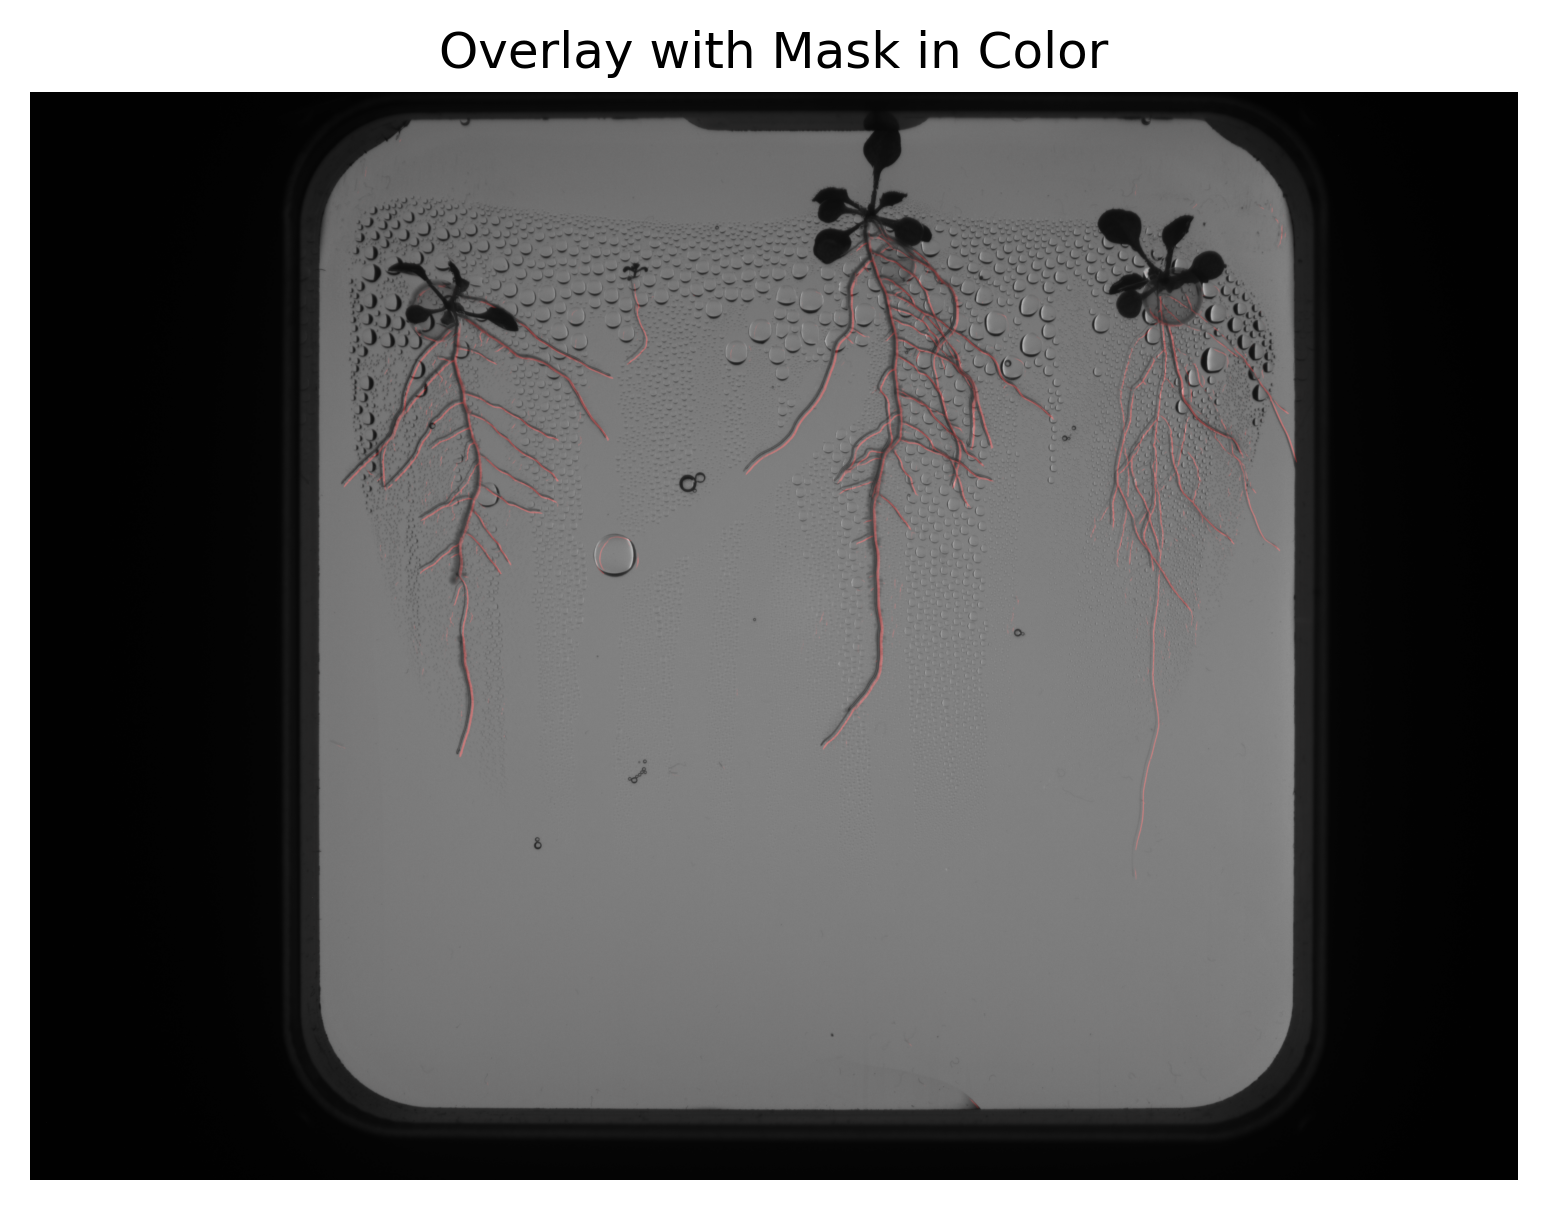

In [41]:
# Convert the original grayscale image to a 3-channel grayscale image
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Convert the mask to a 3-channel binary mask with a specific color
mask_rgb = np.zeros_like(image_rgb)
mask_rgb[..., 3] = uncropped_mask  # Add the mask to the green channel (change index for other colors)

# Create the overlay
overlay_colored = cv2.addWeighted(image_rgb, 0.7, mask_rgb, 0.3, 0)

# Display the overlay
plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(overlay_colored, cv2.COLOR_BGR2RGB))
plt.title("Overlay with Mask in Color")
plt.axis('off')
plt.show()


In [47]:
import cv2

# Normalize the uncropped mask to 0-255 range if not already normalized
uncropped_mask_normalized = (uncropped_mask / uncropped_mask.max() * 255).astype(np.uint8)

# Save the mask as a .tif file
cv2.imwrite('root_mask.tif', uncropped_mask_normalized)
print("Saved final uncropped root mask as 'root_mask'")


Saved final uncropped root mask as 'root_mask'
